# Подготовка данных

Импортируем все необходимые библиотеки и считаем все данные для построения рекомендательной системы из полученных файлов.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import surprise
import sklearn 
%matplotlib inline


links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')



Взглянем на то, как выглядят данные.

In [85]:
links.head(10)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
5,6,113277,949.0
6,7,114319,11860.0
7,8,112302,45325.0
8,9,114576,9091.0
9,10,113189,710.0


In [86]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [87]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [88]:
print("Уникальных фильмов:")
print(len(set(ratings['movieId'])))
print("Уникальных юзеров:")
print(len(set(ratings['userId'])))

Уникальных фильмов:
9724
Уникальных юзеров:
610


In [89]:
tags.head(10)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
5,2,89774,Tom Hardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,Leonardo DiCaprio,1445715051
8,2,106782,Martin Scorsese,1445715056
9,7,48516,way too long,1169687325


# Коллаборативная фильтрация
Для начала, реализуем наиболее простые методы построения рекомендательных систем. Для этого нам понадобится только информация об оценках пользователей.

Построим матрицу,каждый элемент [i,j], которой будет содержать информацию о том, как i-тый пользователь оценил j-тый фильм. Однако, так как ID фильмов в данных идет не по порядку, надо их отмасштабировать, для удобства составления матрицы.

In [90]:
def movie_scale(movie_id):
    scaled = np.where(movie_ids == movie_id)[0][0] + 1
    return scaled

In [135]:
data=ratings.drop('timestamp', axis=1)

movie_ids = data['movieId'].unique()
data['movieId'] = data['movieId'].apply(movie_scale)

Разобьем выборку на обучающую и тестовую, используя модули библиотеки sklearn:

In [136]:
from sklearn.model_selection import train_test_split

(train_data,test_data) = train_test_split(data,test_size=0.3,random_state=0)

print(len(train_data),len(test_data))

70585 30251


Построим матрицу для обучающего и тестового набора данных.

In [93]:
n_users = len(data['userId'].unique())
n_movies = len(data['movieId'].unique())

def matrix_construction(df):
    matrix=np.zeros((n_users,n_movies))
    for row in df.itertuples():
        matrix[row[1]-1][row[2]-1]=row[3]
    return matrix

test_matrix=matrix_construction(test_data)
train_matrix=matrix_construction(train_data)


Теперь посчитаем косинусное расстояние(меру похожести) для фильмов и пользователей, воспользовавшись готовой реализацией из библиотеки sklearn.

In [94]:
from  sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(train_matrix, metric='cosine')
item_similarity = pairwise_distances(train_matrix.T, metric='cosine')

Сделаем матрицу train_matrix_mean, где все пропущенные занчения заполнены средним рейтингом каждого itemа, чтобы в дальнейшем использоать ее для обучения. Значения среднего, для фильмов, колторых нет в тестовой выборке возьмем как среднее по всем фильмам.

In [95]:
train_matrix_mean=pd.DataFrame(np.where(train_matrix==0, np.nan ,train_matrix) )
means=train_matrix_mean.mean(skipna=True)
average=np.mean(test_data['rating'])
means=means.fillna(average)
type(train_matrix_mean)
train_matrix_mean=train_matrix_mean.fillna(means).to_numpy()

Напишем функцию, которая будет считать RMSE, принимаю на вход матрицы похожести.

In [96]:
from sklearn.metrics import mean_squared_error 

def rmse(prediction, target):
    prediction = prediction[target.nonzero()].flatten()
    target = target[target.nonzero()].flatten()
    mse = mean_squared_error(prediction, target, squared=False)
    return mse

Посмотрим, какие результаты дают нам средние рейтинги по каждому фильму, в дальнейшем будем использовать это как baseline:

In [97]:
print("Baseline:")
print(rmse(train_matrix_mean,test_matrix))

Baseline:
0.9885430039208778


## Рекомендации основанные на среднем рейтинге похожих пользователей/фильмов

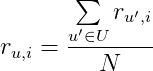

    N — количество пользователей, похожих на пользователя u,
    U — множество из N похожих пользователей,
    u' — пользователь, похожий на пользователя u (из множества U),
    r{u',i} — оценка пользователя u' фильму i,
    r{u,i} — предсказанная оценка фильма i.

Реализуем функцию, подсчитывающую предсказания на основе приведенной выше формулы:

In [16]:
def predict_user(N):
    
    #Создадим трехмерный массив для хранения рейтингов наиболее похожих пользователей:
    top_similar_ratings = np.zeros((n_users, N, n_movies))
    for i in range(n_users):
        #Найдем индексы наиболее похожих пользователей, основываясь на ранее посчитаном косинусном расстоянии.
        top_similar_users_indexes = user_similarity[i].argsort()[1:N + 1]
        #Запишим в наш массив оценки фильмов, которые давали наиболее похожие пользователи:
        top_similar_ratings[i] = train_matrix_mean[top_similar_users_indexes]

    #Вычислим финальное предсказание для всех фильмов, основываясь на приведенной формуле:
    pred = np.zeros((n_users, n_movies))
    for i in range(n_users):
        pred[i] = top_similar_ratings[i].sum(axis=0) / N
    
    return pred


А теперь реализуем такую же функцию, но которая будет предсказывать значение на основе оценок наиболее похожих фильмов, а не пользователей.

In [17]:
def predict_film(N):
    
    top_similar_ratings = np.zeros((n_movies, N, n_users))

    for i in range(n_movies):
        top_similar_movies_indexes = item_similarity[i].argsort()[1:N + 1]
        top_similar_ratings[i] =  train_matrix_mean.T[top_similar_movies_indexes]
        
    pred = np.zeros((n_movies, n_users))
    for i in range(n_movies):
        pred[i] = top_similar_ratings[i].sum(axis=0) / N
    
    return pred.T

Пронаблюдаем зависимость ошибки от количества ближайших пользователей/фильмов:

No handles with labels found to put in legend.


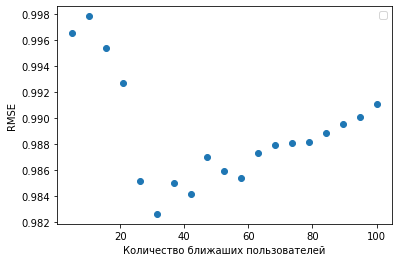

In [18]:
x = np.linspace(5, 100,19)
y=[]
for i in range(len(x)):
    y.append(rmse(predict_film(int(x[i])), test_matrix))
    

plt.scatter(x, y)
plt.ylabel('RMSE')
plt.xlabel('Количество ближаших пользователей')
plt.legend(loc='best')

No handles with labels found to put in legend.


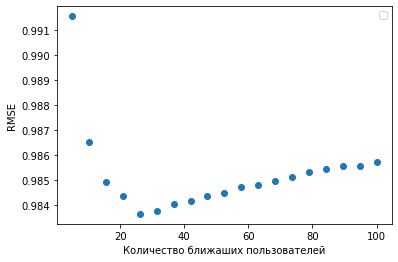

In [19]:
x = np.linspace(5, 100,19)
y=[]
for i in range(len(x)):
    y.append(rmse(predict_user(int(x[i])), test_matrix))
    
plt.scatter(x, y)
plt.ylabel('RMSE')
plt.xlabel('Количество ближаших пользователей')
plt.legend(loc='best')

In [20]:
print("Item-based best:")
print(rmse(predict_film(35), test_matrix))
print("User-based best:")
print(rmse(predict_user(30), test_matrix))

Item-based best:
0.9851340081860326
User-based best:
0.9838100789896128


## Рекомендации на основе средних оценок похожих пользователей и средих оценок пользователя

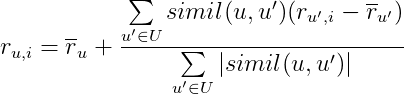
r с чертой — средняя оценка соответствующего пользователя

simil(u,u*)-коэфицент похожести

r{u',i} — оценка пользователя u' фильму i,

In [24]:
def predict_user_2(N):
    
    #Создадим массив для записи индексов наиболее похожих пользователей, а так же массив для записи предсказанных значений :
    top_similar_users_indexes = np.zeros((n_users, N))
    pred = np.zeros((n_users, n_movies))
    #Посчитаем средние оцценки пользователей, основываясь только на тех оценках, которые пользователи ставили сами:
    user_means=pd.DataFrame(np.where(train_matrix==0, np.nan ,train_matrix)).mean(axis=1,skipna=True).to_numpy()
    
    for i in range(n_users):
        #Запишем все индексы наиболее похожих пользователей 
        top_similar_users_indexes[i] = user_similarity[i].argsort()[1:N + 1]
        indexes = top_similar_users_indexes[i].astype(np.int)
        #Посчитаем все разности оценок пользователя и средних оценко похожих пользователей
        diff_ratings = train_matrix_mean[indexes] - train_matrix_mean[indexes].mean()
        #Вычислим числитель, скалярно умножив массив всех косинусных расстояний похожих пользователей на полученную ранее разность 
        numerator =user_similarity[i][indexes].dot(diff_ratings)
        #Вычислим знаменатель, проссумироваав все косинусные расстояния 
        denumerator = user_similarity[i][indexes].sum()
        
        #Так как по фурмуле у нас может получиться занчение больше 5, заменим все значения больше 5, пятерками.
        predicted = user_means[i] + numerator / denumerator
        pred[i]=np.where(predicted>5, 5,predicted)
            
    return pred

No handles with labels found to put in legend.


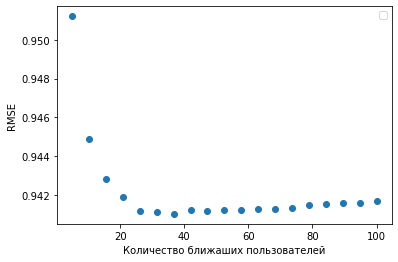

In [25]:
x = np.linspace(5, 100,19)
y=[]
for i in range(len(x)):
    y.append(rmse(predict_user_2(int(x[i])), test_matrix))
    
plt.scatter(x, y)
plt.ylabel('RMSE')
plt.xlabel('Количество ближаших пользователей')
plt.legend(loc='best')

In [26]:
print("User-based best:")
print(rmse(predict_user_2(35), test_matrix))

User-based best:
0.941046234377398


Очевидно, что реализовывать такой же подход для фильмов не имеет смысла, так как мы обучались на массиве, заполненном их  средними оценками.

# Матричные разложения(SVD)

Воспользуемся матричными разложениями. 
SVD-Singular Vector Decomposition. Где  U - ортогональная левая сингулярная матрица, которая описывает взаимосвязь между пользователями и неявными факторами, S - диагональная матрица, которая описывает вес каждого неявного фактора, а V - это диагональная правая сингулярная матрица, которая указывает на сходство между элементами и невными факторами.

Напишем функцию, которая будет принимать на вход нашу исходную матрицу, а так же число неявных признаков, которые мы будем учитывать

In [24]:
from scipy.linalg import sqrtm

def svd(train, k):
    # Возьмем стандартную реализацию данного метода из библиотеки Numpy
    U, s, V=np.linalg.svd(train, full_matrices=False)
    # Сделаем из S диаганальную матрицу 
    s=np.diag(s)
    # выберем только k неявных признаков 
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    return UsV

No handles with labels found to put in legend.


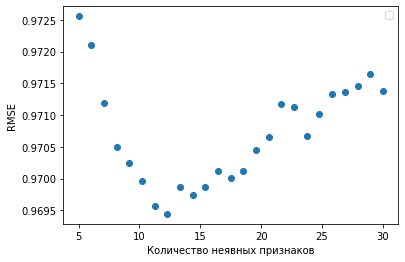

In [25]:
x = np.linspace(5, 30,25)
y=[]
for i in range(len(x)):
    y.append(rmse(svd(train_matrix_mean,int(x[i])), test_matrix))
    
plt.scatter(x, y)
plt.ylabel('RMSE')
plt.xlabel('Количество неявных признаков')
plt.legend(loc='best')

In [26]:
print("My SVD best:")
print(rmse(svd(train_matrix_mean,12), test_matrix))

My SVD best:
0.9694424095599659


Теперь попробуем уже готовую реализацию SVD из библиотеки surprise c различными параметрами:


In [133]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import GridSearchCV

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data[['userId','movieId','rating']], reader)


param_grid = {'n_factors':[50,100,150],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'],refit=True,cv=3)

gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8627866698519728
{'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}


In [134]:
gs.predict(407,3).est

3.2521590913864573

# Выводы

In [31]:
df = pd.DataFrame({'Method': ['Baseline','Рекомендации основанные на среднем рейтинге похожих фильмов','Рекомендации основанные на среднем рейтинге похожих пользователей','My SVD', 'Рекомендации на основе средних оценок похожих пользователей и средих оценок пользователя','Surprise SVD'], 'RMSE_Score': [0.9885430039208778, 0.9851340081860326,0.9838100789896128,0.9694424095599659,0.941046234377398,0.8617641944266964]})
df.head(6)

,Method,RMSE_Score
0,Baseline,0.988543
1,Рекомендации основанные на среднем рейтинге по...,0.985134
2,Рекомендации основанные на среднем рейтинге по...,0.983810
3,My SVD,0.969442
4,Рекомендации на основе средних оценок похожих ...,0.941046
5,Surprise SVD,0.861764


#### Посмотрим, какие фильмы оценил юзер номер 407:

In [19]:
user_films=ratings.set_index('userId')
user_films=user_films.drop('timestamp', axis=1)
user_films=user_films.loc[407]
user_films_id=user_films['movieId'].to_numpy()

movies_=movies
movies_=movies_.set_index('movieId')
movies_=movies_.drop('genres', axis=1)
movies_=movies_.loc[user_films_id]
movies_['title'].to_numpy()

user_films.insert(2,"title",movies_['title'].to_numpy())
user_films=user_films.drop('movieId', axis=1)
user_films

,rating,title
userId,,
407,4.0,Star Wars: Episode IV - A New Hope (1977)
407,3.0,Léon: The Professional (a.k.a. The Professiona...
407,3.0,Die Hard (1988)
407,4.0,Star Wars: Episode V - The Empire Strikes Back...
407,3.0,"Terminator, The (1984)"
407,4.0,Indiana Jones and the Last Crusade (1989)
407,4.0,Saving Private Ryan (1998)
407,5.0,"Matrix, The (1999)"
407,5.0,Fight Club (1999)


Видно, что юзеру номер 8 нравятся триллеры, приключения и фентези, а так же,в основном, не нравятся мультики.

Пронаблюдаем, какие фильмы были бы рекомендованны юзеру 8, каждым из методов:

In [35]:
def recomendation(user_num,pred_matrix):
    #создадим массив идексов всех не просмотренных фильмов
    indexes_zero=np.where(train_matrix[user_num]==0)[0]
    #выберем  5 самых высоких оценок не оцененных фильмов и найдем их индексы
    pred_indexes=np.argsort(pred_matrix[user_num])
    selected_id=[]
    for i in range(len(pred_indexes)):
        if (len(selected_id)==5):
            break
        #Будем проверять, есть ли индекс нулевого элемента среди наибольших оценок
        if (np.in1d(indexes_zero,pred_indexes[i]).any()==True):
            selected_id.append(pred_indexes[i])
    selected_id=np.array(selected_id).astype(int)
    #Так как мы меняли индексы фильмов,вернемся к изначальным индексам
    real_indexes=movie_ids[selected_id]
    #выведем названия этих фильмов
    movies_pred=movies
    movies_pred=movies_pred.set_index('movieId')
    movies_pred=movies_pred.drop('genres', axis=1)
    
    return movies_pred.loc[real_indexes]
    

### Baseline

In [31]:
recomendation(407,train_matrix_mean)

,title
movieId,
86068,Films to Keep You Awake: The Christmas Tale (P...
77427,"Human Centipede, The (First Sequence) (2009)"
136297,Mortal Kombat: The Journey Begins (1995)
8632,Secret Society (2002)
125221,The Beast of Hollow Mountain (1956)


### Рекомендации основанные на среднем рейтинге похожих пользователей

In [32]:
recomendation(407,predict_user(30))

,title
movieId,
152079,London Has Fallen (2016)
144352,Unforgiven (2013)
92681,Journey 2: The Mysterious Island (2012)
173307,The Gracefield Incident (2015)
157172,Wizards of the Lost Kingdom II (1989)


### Рекомендации основанные на среднем рейтинге похожих фильмов

In [33]:
recomendation(407,predict_film(35))

,title
movieId,
7030,Radio Flyer (1992)
2038,"Cat from Outer Space, The (1978)"
1083,"Great Race, The (1965)"
102880,After Earth (2013)
8387,Police Academy: Mission to Moscow (1994)


### My SVD

In [34]:
recomendation(407,svd(train_matrix_mean,12))

,title
movieId,
76030,Case 39 (2009)
109897,Son of God (2014)
92681,Journey 2: The Mysterious Island (2012)
77798,"Nightmare on Elm Street, A (2010)"
137517,Carnival Magic (1981)


### Рекомендации основанные на среднем рейтинге похожих пользователей

In [35]:
recomendation(407,predict_user_2(35))

,title
movieId,
61818,"Crow, The: Wicked Prayer (2005)"
4412,"Thing with Two Heads, The (1972)"
77798,"Nightmare on Elm Street, A (2010)"
5672,Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (...
82095,Skyline (2010)


### Surprise SVD

In [139]:
def recomendation_surp(user_num):
    #получим оценки 
    y = []
    for i,row in test_data.iterrows():
        y.append(gs.predict(row['userId'], row['movieId']).est)
    #создадим массив идексов всех не просмотренных фильмов
    indexes_zero=np.where(train_matrix[user_num]==0)[0]
    #выберем  5 самых высоких оценок не оцененных фильмов и найдем их индексы
    pred_indexes=np.argsort(y)
    selected_id=[]
    for i in range(len(pred_indexes)):
        if (len(selected_id)==5):
            break
        #Будем проверять, есть ли индекс нулевого элемента среди наибольших оценок
        if (np.in1d(indexes_zero,pred_indexes[i]).any()==True):
            selected_id.append(pred_indexes[i])
    selected_id=np.array(selected_id).astype(int)
    #Так как мы меняли индексы фильмов,вернемся к изначальным индексам
    real_indexes=movie_ids[selected_id]
    #выведем названия этих фильмов
    movies_pred=movies
    movies_pred=movies_pred.set_index('movieId')
    movies_pred=movies_pred.drop('genres', axis=1)
    
    return movies_pred.loc[real_indexes]

In [140]:
recomendation_surp(407)

,title
movieId,
100068,Comme un chef (2012)
7705,Pat and Mike (1952)
7348,Spartan (2004)
7707,"He Said, She Said (1991)"
103245,Adam and Eve (National Lampoon's Adam & Eve) (...


# Content based рекомендации 

Представим названия в виде векторов используя TF-IDF.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer(stop_words='english')
overview_matrix = tfidf.fit_transform(movies['title']).toarray()

Напишем функцию, выдающую рекомендации для юзера, проссумируя все возможные фильмы с коэфицентами, равными оценке фильма, а затем на количество оцененных фильмов:

In [28]:
from scipy.spatial.distance import cosine

def recomedation_content_based(user_ID):
    #создадим массивы рейтингов и идексов всех просмотренных фильмов
    user_films=ratings.set_index('userId')
    user_films=user_films.drop('timestamp', axis=1)
    user_films=user_films.loc[user_ID]
    film_ratings=user_films['rating'].to_numpy()
    film_ids=user_films['movieId'].to_numpy()
    #Перейдем от Id фильмов к их индексам в матрице TF-IDF
    matrix_index=movies[movies['movieId'].isin(film_ids)].index.to_numpy()
    # вычислим вектор юзера:
    summ=0
    for i in range(len(matrix_index)):
        summ+=film_ratings[i]*overview_matrix[matrix_index[i]]
    user_vector=summ
    #вычислим косинусное расстояние до каждого фильма, и порекоменюдуем ближайшие 5 фильмов 
    sim=[]
    for i in range(len(overview_matrix)):
        sim.append(cosine(user_vector,overview_matrix[i]))  
    # Будем рекомендовать только из не просмотренных, поэтому выставим у всех не просмотренных фильмов значение 2:
    for i in range(len(matrix_index)):
        sim[matrix_index[i]]=2
    top_sim_index=np.argsort(sim)[:5]
    
    return movies.loc[top_sim_index]


In [29]:
recomedation_content_based(407)

,movieId,title,genres
1577,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
9155,147936,The Lord's Lantern in Budapest (1999),Comedy|Drama
6866,62437,W. (2008),Drama
6711,58627,Never Back Down (2008),Action
5985,36529,Lord of War (2005),Action|Crime|Drama|Thriller|War


Видно, что данные рекомендации подходят нашему пользователю, так как он высоко оценил остальные части Властелина Колец. Однако порекомендовались фильмы со словом lord в названии, хотя они совсем не похожи на Властелина колец.

# Popularity based

Будем рекомендовать юзеру наиболее популярные айтемы, которые он не смотрел.

In [353]:
def recomedation_popularity_based(user_ID):
    # Для начала посчитаем вес каждого фильма, сложив все рейтинги.
    Ratings=ratings.set_index('movieId')
    summ=[]
    for i in range(len(movie_ids)):
        summ.append(Ratings.loc[movie_ids[i]]['rating'].sum())
    #Теперь пронаблюдаем какие фильмы пользователь уже смотрел, чтобы не рекомендовать ему то же самое.
    #Для этого выставим у просмотренных фильмов рейтинг 0 
    watched=Ratings[Ratings['userId']==user_ID].index.to_numpy().astype(int)
    for i in range(len(watched)):
        summ[int(np.where(movie_ids==watched[i])[0])]=0
    top=np.array(summ).argsort()[::-1]
    #Теперь перейдем к movieID
    real_indexes=movie_ids[top[:5]]
    #выведем названия этих фильмов
    movies_pred=movies
    movies_pred=movies_pred.set_index('movieId')
    movies_pred=movies_pred.drop('genres', axis=1)
    return movies_pred.loc[real_indexes]

In [354]:
recomedation_popularity_based(407)

,title
movieId,
318,"Shawshank Redemption, The (1994)"
356,Forrest Gump (1994)
296,Pulp Fiction (1994)
593,"Silence of the Lambs, The (1991)"
110,Braveheart (1995)


Видно, что наши рекомендации верны, так как эти фильмы всегда находятся в топе.